In [1]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime

In [445]:
dataset = h5py.File('simu_HDF_thistimeforReal.h5', 'r') #load data
num_diodes = dataset['Num_diodes'][...] #separate the data into each key within the data file
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
histgrid = histgrid[:-10,:,:] #redefine the shape and size of histgrid by removing the last 10 events
output = np.vstack((x_pos,y_pos)) #define new, single variable for x and y position
output = np.transpose(output) #original definition was sideways, so we transposed it

#values = [117,174]
#list of locations (by index) in histgrid which have unusable data due to peaks being in incorrect/weird locations

new_histgrid = np.delete(histgrid, values, 1)
#histgrid = new_histgrid
#deletes "values" from histgrid and then redefines histgrid to not contain those values
#done as 2 lines so you can comment out the 2nd and compare histgrid to new_histgrid if needed

print(histgrid.shape)

where_are_NaNs = isnan(histgrid) #removes any NaN values within histgrid; shouldn't be a problem with "values" removed
histgrid[where_are_NaNs] = 0

dataset.close()

(991, 342, 132)


In [446]:
def data_compile(histdata):
    data = []  #creates empty arrays for data and labels
    labels = []
    for i in range(histdata.shape[1]):
        for j in range(1,histdata.shape[0]):
            data.append(histdata[j,i,0:132]) #puts histgrid data inside of "data"
            labels.append(output[i]) #puts x,y _pos into "labels"
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)

#to make sure everything is the correct shape
print(all_data.shape)
print(all_labels.shape)

(338580, 132)
(338580, 2)


In [447]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [513]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [514]:
print(train_data.ndim)
print(train_data.shape)
print(train_data[0])

2
(270864, 132)
[0.         0.         0.         0.         0.0029482  0.0029482
 0.         0.         0.0029482  0.0029482  0.         0.
 0.         0.         0.         0.0029482  0.0058964  0.00884459
 0.02653378 0.08549775 0.1680473  0.15330631 0.15625451 0.13266892
 0.06486036 0.03832658 0.0058964  0.0029482  0.         0.
 0.         0.         0.0029482  0.         0.0029482  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0029482  0.         0.         0.
 0.         0.         0.         0.         0.         0.0029482
 0.66629281 0.30661262 0.         0.         0.         0.0029482
 0.         0.         0.         0.         0.0029482  0.
 0.         0.         0.         0.22406307 0.30661262 0.25649325
 0.01179279 0.         0.         0.0058964  0.         0.0029482
 0.         0.0029482  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0058964
 0.         0.         0.         0.    

In [515]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [516]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [517]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [518]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=100,
                    batch_size = 32,
                    callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/100
5926/5926 [==============================] - 22s 4ms/step - loss: 4.6297 - mae: 0.7393 - mse: 4.6297 - val_loss: 0.3987 - val_mae: 0.4186 - val_mse: 0.3987
Epoch 2/100
5926/5926 [==============================] - 26s 4ms/step - loss: 0.2737 - mae: 0.3661 - mse: 0.2737 - val_loss: 0.2693 - val_mae: 0.3500 - val_mse: 0.2693
Epoch 3/100
5926/5926 [==============================] - 25s 4ms/step - loss: 0.1513 - mae: 0.2612 - mse: 0.1513 - val_loss: 0.1449 - val_mae: 0.2005 - val_mse: 0.1449
Epoch 4/100
5926/5926 [==============================] - 23s 4ms/step - loss: 0.1213 - mae: 0.2219 - mse: 0.1213 - val_loss: 0.1436 - val_mae: 0.1999 - val_mse: 0.1436
Epoch 5/100
5926/5926 [==============================] - 25s 4ms/step - loss: 0.1046 - mae: 0.2010 - mse: 0.1046 - val_loss: 0.1224 - val_mae: 0.1687 - val_mse: 0.1224
Epoch 6/100
5926/5926 [==============================] - 26s 4ms/step - loss: 0.0927 - mae: 0.1798 - mse: 0.0927 - val_loss: 0.1178 - val_mae: 0.1512 - val_mse:

5926/5926 [==============================] - 20s 3ms/step - loss: 0.0407 - mae: 0.0616 - mse: 0.0407 - val_loss: 0.0847 - val_mae: 0.0433 - val_mse: 0.0847
Epoch 50/100
5926/5926 [==============================] - 20s 3ms/step - loss: 0.0404 - mae: 0.0583 - mse: 0.0404 - val_loss: 0.0870 - val_mae: 0.0577 - val_mse: 0.0870
Epoch 51/100
5926/5926 [==============================] - 20s 3ms/step - loss: 0.0386 - mae: 0.0591 - mse: 0.0386 - val_loss: 0.0853 - val_mae: 0.0473 - val_mse: 0.0853
Epoch 52/100
5926/5926 [==============================] - 20s 3ms/step - loss: 0.0396 - mae: 0.0590 - mse: 0.0396 - val_loss: 0.0840 - val_mae: 0.0429 - val_mse: 0.0840
Epoch 53/100
5926/5926 [==============================] - 20s 3ms/step - loss: 0.0410 - mae: 0.0586 - mse: 0.0410 - val_loss: 0.0837 - val_mae: 0.0525 - val_mse: 0.0837
Epoch 54/100
5926/5926 [==============================] - 27s 5ms/step - loss: 0.0399 - mae: 0.0554 - mse: 0.0399 - val_loss: 0.0852 - val_mae: 0.0504 - val_mse: 0.0852

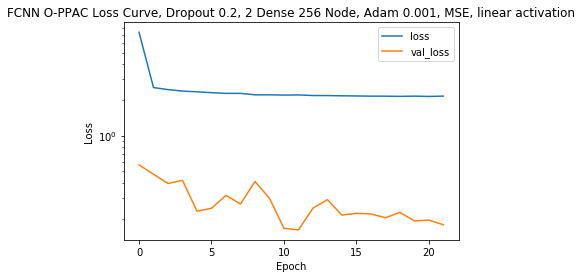

In [511]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.001, MSE, linear activation")
plt.show()

In [512]:
#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2117/2117 - 3s - loss: 0.1459 - mae: 0.2661 - mse: 0.1459


In [471]:
#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [472]:
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = [i[0] for i in test_labels]
y_test1 = [i[1] for i in test_labels]

x_test = np.array(x_test1)
y_test = np.array(y_test1)


x_test[0]
y_test[0]

-36.0

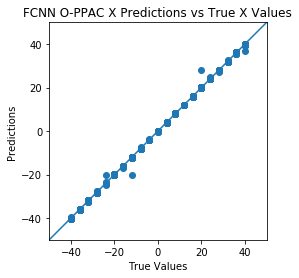

In [473]:
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_x_labels, x_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

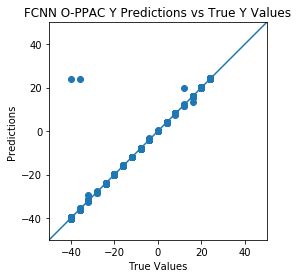

In [474]:
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [492]:
#to find the locations of largest error within my predicted x values
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

xerror_list = [i for i in x_error if abs(i) >= 2]
xerror_list.sort(reverse = True)
print(len(xerror_list))
print(xerror_list)

4
[7.957893371582031, 3.9632205963134766, -3.01898193359375, -8.036779403686523]


In [496]:
#to find the locations of largest error within my predicted y values
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

yerror_list = [i for i in y_error if abs(i) >= 2]
yerror_list.sort(reverse = True)
print(len(yerror_list))
print(yerror_list)

5
[63.9300479888916, 59.9300479888916, 7.75358772277832, 2.4263439178466797, -2.837209701538086]


In [485]:
#in "bad value" plug in x error value to find the index for x_pos and y_pos
bad_value = -19.21713638305664
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

#the common value between the x and y arrays is the index of the bad data

#67, 35, 302, 337

[337]


In [481]:
#in "bad value" plug in y error value to find the index for x_pos and y_pos
bad_value = -2.837209701538086
x_locat = np.where(x_pos == (np.array(x_test[y_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[y_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

#the common value between the x and y arrays is the index of the bad data

#57, 6, 225, 299, 226

[226]


67710


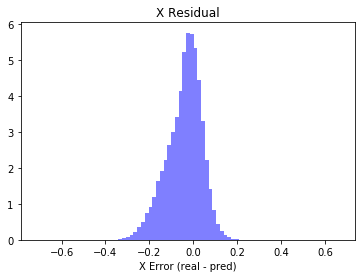

In [504]:
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

#error_list_x = x_error
error_list_x = [i for i in x_error if abs(i) <= .75]
print(len(error_list_x))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')

plt.title(r'X Residual')

plt.show()

67710


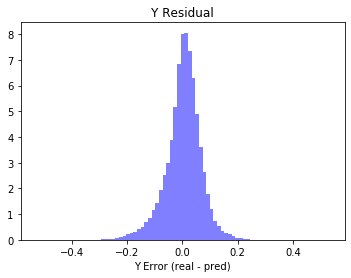

In [503]:
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

#error_list_y = y_error
error_list_y = [i for i in y_error if abs(i) <= .75]
print(len(error_list_y))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')

plt.title(r'Y Residual')
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()